# Vehicle Counting with YOLOv3

#### pre-trained weight file from `darknet`: https://pjreddie.com/darknet/yolo/

![weight files](images/wt-files.png)

In this project, I used the second one: `YOLOv3-416` model and `COCO` dataset. The evaluation metric: `mAP(mean Average Precision)` of this model is $55.3$

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

In [3]:
classes = []
with open("coco.names", "rb") as f:
    classes = f.read().splitlines()
print(classes)
myClass = ["car", "bus", "truck", "motorbike", "bicycle"]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


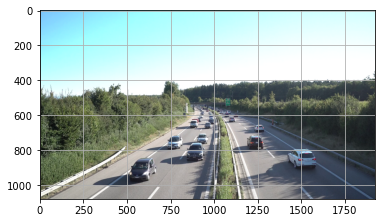

In [44]:
cap = cv2.VideoCapture("Highway.mp4")
success, img = cap.read()
cvtImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cvtImg)
plt.grid(True, "major", axis="both")
plt.show()

countDown = 0
countUp = 0

while success:
    success, img = cap.read()
    height, width = img.shape[0:2]
    #print(height, width)
    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0, 0, 0), swapRB = True, crop = False)

    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)
    #print(output_layers_names) -> ['yolo_82', 'yolo_94', 'yolo_106']
    #print(layerOutputs)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size = (len(boxes), 3))
    
    #coloring top
    img[0:100, 0:width] = [0,0,255]
    cv2.putText(img,'VEHICLE COUNT:',(10,60),font,2.5,(0,0,0),3)
    cv2.putText(img,'Downward:',(500,60),font,2.5,(0,0,0),3)
    cv2.putText(img,'Upward:',(1600,60),font,2.5,(0,0,0),3)
    
    #draw line as lane divider
    cv2.line(img, (350, 900), (1010, 900), (0, 255, 255), 3)
    cv2.line(img, (1100, 800), (1650, 800), (0, 255, 255), 3)

    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))
            color = colors[i]
            
            if label in myClass:
                rect = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
                #center = cv2.circle(img, (int(x+w/2),int(y+h/2)), radius=2, color=(0, 0, 255), thickness=-1)
                rect[(y-15):(y+5), x:(x+w)] = color
                cv2.putText(img, label + " " + confidence, (x, y), font, 1.3, (0,0,0), 2)
            
                #logics for vehicle counting
                bikeC1y = int(y+h/2)        
                linC1y = 900
                bikeC2y = int(y+h/2)        
                linC2y = 800
                if(bikeC1y<linC1y+4 and bikeC1y>linC1y-4 and x <= 1010):
                    countDown = countDown+1
                    cv2.line(img, (350, 900), (1010, 900), (0,0,255), 3)
                if(bikeC2y<linC2y+4 and bikeC2y>linC2y-3 and x >= 1100):
                    countUp = countUp+1
                    cv2.line(img, (1100, 800), (1650, 800), (0,0,255), 3)
                cv2.putText(img, str(countDown), (760,60), font, 2.5, (0,0,0), 3)
                cv2.putText(img, str(countUp), (1800,60), font, 2.5, (0,0,0), 3)

    img = cv2.resize(img, (1300, 700))
    cv2.imshow("Image", img)
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()        
cv2.destroyAllWindows()

#### IoU

For object detection, we use `IoU`(Intersection over Union)

if, A = ground truth bounding box and B = predicted bounding box then -

$IoU=\frac{A\cap{B}}{A\cup{B}}$

`IoU` tells us how well predicted and the ground truth bounding box overlap. We can define the `IoU` threshold(say 0.5) for classifying whether the prediction is a true positive or a false positive.
- **TP:** if $IoU > 0.5$
- **FP:** if $IoU < 0.5$
- **FN:** 
    - if there is no detection at all/missed the target
    - $IoU>0.5$ but wrong classification
    
#### `mAP` calculation from `AUC` of precision-recall

$precision = \frac{TP}{TP+FP}$

$recall = \frac{TP}{TP+FN}$

If we plot` precision vs recall`, we can calculate the AP: $AP = AUC$

Then, The $mAP$ for object detection is the average of the AP calculated for all the classes. But under the `COCO` context, there is no difference between `AP and mAP`. The quote from COCO:
> AP is averaged over all categories. Traditionally, this is called “mean average precision” (mAP). We make no distinction between AP and mAP (and likewise AR and mAR) and assume the difference is clear from context.

#### Relationship between mAP and confidence score

$mAP = \frac{1}{confidenceScore}$

So the higher the confidence score threshold the lower will be the mAP. In this project the confidence score threshold is set to $0.5$

#### confidence score

is the probability that an anchor box contains an object.

Each bounding box consists of five predictions: x, y, w, h, and confidence.
- **(x,y):** Coordinates representing the center of the box.
- **w:** Width of the bounding box.
- **h:** Height of the bounding box.

See the above code how I got the confidence score:
```py
scores = detection[5:]
```

#### Loss function

The loss consists of two parts.
1. the localization loss for bounding box offset prediction and,
2. the classification loss for conditional class probabilities.

### trying to use mxnet, gluoncv

In [20]:
# from gluoncv import model_zoo, data, utils
# from matplotlib import pyplot as plt
# import mxnet as mx

# net = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)

# class_dict={0:"car",1:"bicycle",2:"motorcycle",3:"bus",4:"truck"}
# infer_of_interest=['car', 'bicycle', 'motorcycle', 'bus', 'truck']
# net.reset_class(infer_of_interest, reuse_weights=infer_of_interest)

# ##########################################################################

# cap = cv2.VideoCapture("Highway.mp4")
# success, img = cap.read()
# height, width = img.shape[0:2]

# count = 0
# font = cv2.FONT_HERSHEY_PLAIN

# #coloring top
# img[0:70, 0:width] = [0,0,255]
# cv2.putText(img,'VEHICLE COUNT:',(10,50),font,1.5,(0,0,0),2)

# #draw line as lane divider
# cv2.line(img, (670, height), (925, 350), (0, 255, 255), 3)

# while success:
#     success, img = cap.read()
#     height, width = img.shape[0:2]
#     img = mx.nd.array(img).astype('uint8')
#     x, img = data.transforms.presets.yolo.transform_test(img, short=512, max_size=1024)

#     class_IDs, scores, bounding_boxes = net(x)

#     boxes = bounding_boxes[0].asnumpy()
#     confidences = scores[0].asnumpy()
#     class_ids = class_IDs[0].asnumpy()
    
#     colors = np.random.uniform(0, 255, size = (len(boxes), 3))

#     for i in range(len(confidences)):
#         if float(confidences[i])<0.3: 
#             continue
#         elif int(class_ids[i])==-1:
#             break
#         else:
#             img=cv2.rectangle(img,(boxes[i][0],boxes[i][1]),(boxes[i][2],boxes[i][3]),colors[i],2)
#             #img=cv2.rectangle(img,(all_bbox[i][0],all_bbox[i][1]),(all_bbox[i][2],all_bbox[i][3]),(255,0,0),2)
            
#             img=cv2.putText(img, class_dict[int(class_ids[i])], (boxes[i][0],boxes[i][1]),
#                         font, 1.4, (0,0,0), 2)

#     cv2.imshow("Image", img)
#     if cv2.waitKey(1) & 0xFF == 27:
#         break
        
# cap.release()        
# cv2.destroyAllWindows()